# Sentiment Analysis with an RNN and a Pretrained Embedding (GloVe)

In this notebook, I implement a recursive neural network (RNN) composed of layers of GRU cells. This RNN will be trained using the traning set of the IMDB reviews database and it will be tested on its corresponding testing set. These databases has been downloaded from:
__[http://ai.stanford.edu/~amaas/data/sentiment/](http://ai.stanford.edu/~amaas/data/sentiment/)__

In our neural network we will make use of GloVe, a pre-trained embedding layer whose details can be consulted here:
__[https://nlp.stanford.edu/projects/glove/](https://nlp.stanford.edu/projects/glove/)__

The model is implemented using pyTorch.


# IMPORTS
Let's import the modules we will use


In [1]:
import os
import pickle
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from string import punctuation
from collections import Counter

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
plt.style.use('seaborn')

## Using GPUs?
Let's check if a GPU is available and select the device use for optimization

In [3]:
# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


---
## Load the pretrained embedding

We will use glove.6B.300d.txt.

In [4]:
glove_file = 'glove.6B.300d.txt'

Lets load the embedding information

In [5]:
word_to_int = {'<pad>': 0}
emb_vectors = ['Fill at the End']
words = ['<pad>']
with open(glove_file, 'rb') as f:
    idx = 1
    for line in f:
        line = line.decode().split()
        word = line[0]
        words.append(word)
        word_to_int[word] = idx
        emb_vectors.append(np.array(line[1:]).astype(np.float))
        idx += 1
emb_vectors[0] = np.zeros_like(emb_vectors[1])
#convert to np array
emb_vectors = np.array(emb_vectors)
#convert to torch tensor
emb_vectors = torch.from_numpy(emb_vectors).type('torch.FloatTensor')

In [6]:
print(len(words))
print(words[0],words[1],words[-1])

400002
<pad> the <unk>


In [7]:
print(emb_vectors[0])
print(emb_vectors[1])
print(emb_vectors[-1])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

---
## Load in, tokenize and visualize the data

The download data is already divied into train and test data. Each folder is further divided into positive (7-10/10 stars reviews) and negative reviews (1-4/10 stars reviews).

In [8]:
#training positive reviews directory
train_pos_dir = r'aclImdb/train/pos/'
#negative positive reviews directory
train_neg_dir = r'aclImdb/train/neg/'

#List of files with training positive review
train_pos_rev_files = os.listdir(train_pos_dir)
#List of files with training negative review
train_neg_rev_files = os.listdir(train_neg_dir)
print('TRAIN SET')
print('Number of positive reviews:',len(train_pos_rev_files),'Number of negative reviews:',len(train_neg_rev_files))

TRAIN SET
Number of positive reviews: 12500 Number of negative reviews: 12500


Let's keep track of the number of stars (1-10) awarded to each positive and negative review in the train set

In [9]:
full_train_stars = []
for file in train_pos_rev_files:
    full_train_stars.append(int(file.split('_')[1].split('.')[0]))
for file in train_neg_rev_files:
    full_train_stars.append(int(file.split('_')[1].split('.')[0]))    
full_train_stars = np.array(full_train_stars)

In [10]:
#training positive reviews directory
test_pos_dir = r'aclImdb/test/pos/'
#negative positive reviews directory
test_neg_dir = r'aclImdb/test/neg/'

#List of files with training positive review
test_pos_rev_files = os.listdir(test_pos_dir)
#List of files with training negative review
test_neg_rev_files = os.listdir(test_neg_dir)
print('TEST SET')
print('Number of positive reviews:',len(test_pos_rev_files),'Number of negative reviews:',len(test_neg_rev_files))

TEST SET
Number of positive reviews: 12500 Number of negative reviews: 12500


Let's keep track of the number of stars (1-10) awarded to each positive and negative review in the test set

In [11]:
test_stars = []
for file in test_pos_rev_files:
    test_stars.append(int(file.split('_')[1].split('.')[0]))
for file in test_neg_rev_files:
    test_stars.append(int(file.split('_')[1].split('.')[0]))    
test_stars = np.array(test_stars)

Note that 5- and 6-star reviews are not included in the train or test set

In [12]:
print(np.unique(full_train_stars))
print(np.unique(test_stars))

[ 1  2  3  4  7  8  9 10]
[ 1  2  3  4  7  8  9 10]


#### Target Matrices
Let's create numpy arrays that hold the train and test labels. 1 stands for positive and 0 for negative. Since we will stack first the positive reviews and the the negative ones, the first 12500 elements are ones and the next 12500 are zeros.

In [13]:
#Train target array
full_train_target = np.zeros(len(train_neg_rev_files)+len(train_neg_rev_files), dtype=int)
full_train_target[:len(train_neg_rev_files)] = 1
#Test target array
test_target = np.zeros(len(test_neg_rev_files)+len(test_neg_rev_files), dtype=int)
test_target[:len(test_neg_rev_files)] = 1

In [14]:
print(full_train_target.shape, test_target.shape)
print(full_train_target.mean(), test_target.mean())

(25000,) (25000,)
0.5 0.5


#### Remove Contractions
The following function expands common english contractions. There is obviously  plenty of room for improvement. Some 
actions are 100% justified (can't and cannot into can not), while others are rather arbitrary ('s into is)

In [15]:
def remove_contractions(text):
    # Turn ain't into am not (it could be many other oprions such us is not,...)
    text = text.replace("ain't", "am not")
    #Turn can't and annot into can not
    text = text.replace("can't", "can not").replace("cannot", "can not")
    #Turn shan't into shall not
    text = text.replace("shan't", "shall not")
    #Turn won't into will not
    text = text.replace("won't", "will not")
    #Turn y'all into you all
    text = text.replace("y'all", "you all")
    #Turn n't into not
    text = text.replace("n't", " not")
    #Turn 'd into would (it might be had too)
    text = text.replace("'d", " would")
    #Turn 'll into will
    text = text.replace("'ll", " will")
    #Turn 're into are
    text = text.replace("'re", " are")
    #Turn 'm into am
    text = text.replace("'m", " am")
    #Turn 's into is (it could also be has or the posssesive)
    text = text.replace("'s", " is")
    return text

#### Reviews as List of Words
For each review we convert every character to lower case, remove english contructions, then remove punctuation and finally split it into words

Let's start with the train set

In [16]:
full_train_reviews=[]
#Read and tokenize positive reviews
for file_name in train_pos_rev_files:
    with open(train_pos_dir+file_name, 'r',encoding="utf8") as f:
        review = f.read().lower()
        #remove some contractions
        review = remove_contractions(review)
        #remove punctuation
        review = ''.join([c for c in review if c not in punctuation])
        #split in words
        review = review.split()  
    full_train_reviews.append(review)

#Read and tokenize negative reviews
for file_name in train_neg_rev_files:
    with open(train_neg_dir+file_name, 'r',encoding="utf8") as f:
        review = f.read().lower()
        #remove some contractions
        review = remove_contractions(review)
        #remove punctuation
        review = ''.join([c for c in review if c not in punctuation])
        #split in words
        review = review.split()  
    full_train_reviews.append(review)

In [17]:
print(len(full_train_reviews))
print(full_train_reviews[0])

25000
['antwone', 'fisher', 'tells', 'of', 'a', 'young', 'black', 'us', 'navy', 'enlisted', 'man', 'and', 'product', 'of', 'childhood', 'abuse', 'and', 'neglect', 'luke', 'whose', 'hostility', 'toward', 'others', 'gets', 'him', 'a', 'stint', 'with', 'the', 'base', 'shrink', 'washington', 'leading', 'to', 'introspection', 'self', 'appraisal', 'and', 'a', 'return', 'to', 'his', 'roots', 'pat', 'sanitized', 'and', 'sentimental', 'antwone', 'fisher', 'is', 'a', 'solid', 'feelgood', 'flick', 'about', 'the', 'reconciliation', 'of', 'past', 'regrets', 'and', 'closure', 'good', 'old', 'hollywood', 'style', 'entertainment', 'family', 'values', 'entertainment', 'with', 'just', 'a', 'hint', 'of', 'corn', 'b']


Now the test set

In [18]:
test_reviews=[]
#Read and tokenize positive reviews
for file_name in test_pos_rev_files:
    with open(test_pos_dir+file_name, 'r',encoding="utf8") as f:
        review = f.read().lower()
        #remove some contractions
        review = remove_contractions(review)
        #remove punctuation
        review = ''.join([c for c in review if c not in punctuation])
        #split in words
        review = review.split()  
    test_reviews.append(review)

#Read and tokenize negative reviews
for file_name in test_neg_rev_files:
    with open(test_neg_dir+file_name, 'r',encoding="utf8") as f:
        review = f.read().lower()
        #remove some contractions
        review = remove_contractions(review)
        #remove punctuation
        review = ''.join([c for c in review if c not in punctuation])
        #split in words
        review = review.split()  
    test_reviews.append(review)

In [19]:
print(len(test_reviews))
print(test_reviews[0])

25000
['spoilers', 'even', 'though', 'the', 'movie', 'they', 'made', 'me', 'a', 'criminal', 'is', 'nowhere', 'as', 'good', 'as', 'the', 'later', 'john', 'garfield', 'antihero', 'classics', 'like', 'body', 'soul', 'in', '1947', 'force', 'of', 'evil', 'in', '1948', 'and', 'his', 'last', 'and', 'very', 'underrated', 'he', 'ran', 'all', 'the', 'way', 'in', '1951', 'it', 'is', 'the', 'film', 'that', 'defined', 'his', 'career', 'from', 'that', 'point', 'onward', 'until', 'his', 'untimely', 'death', 'on', 'may', '21', '1952', 'at', 'the', 'young', 'age', 'of', '39', 'br', 'br', 'garfiled', 'plays', 'the', 'part', 'of', 'light', 'weight', 'champion', 'johnnie', 'bradfield', 'and', 'later', 'the', 'fugitive', 'from', 'the', 'law', 'jack', 'dorney', 'who', 'is', 'innocent', 'of', 'the', 'murder', 'that', 'he', 'is', 'charged', 'with', 'even', 'though', 'he', 'is', 'been', 'declared', 'officially', 'dead', 'jonnie', 'is', 'manager', 'doc', 'ward', 'robert', 'doc', 'gleckler', 'who', 'during', 'a'

## Training and Validation Sets

We will divide our full train set into a train set and a validation set that will help us to control how our model generalize.
The validation set will be just 10% of the original train set

In [20]:
#90% will remain as training data
train_size = 0.9; test_size = 1-train_size
(train_reviews, valid_reviews, train_y, valid_y, 
 train_stars, valid_stars) = train_test_split(full_train_reviews, full_train_target, full_train_stars,
                                              random_state=123, shuffle=True,
                                              train_size=train_size, test_size=test_size,stratify=full_train_stars)

In [21]:
#Print out the shapes of your resultant feature data
print(len(train_reviews), train_y.shape, train_stars.shape)
print(len(valid_reviews), valid_y.shape, valid_stars.shape)
print(train_y.mean(), valid_y.mean())

22500 (22500,) (22500,)
2500 (2500,) (2500,)
0.5 0.5


In [22]:
#To keep it simple let's create a test_y variable
test_y = test_target

## Fixing the size of the reviews
It is important to xhoose now the word size of our review before we build our vocabulary. That will prevent us from including
words that may appear frequently in our reviews if we keep all the words but not more than five times if we keep, 
let's say, the first 50 words only. Of course, the larger the sequence considered the less important this would be.

In [23]:
######## Sequence length #########
seq_length = 350

## Data pre-processing

Let's get our data into the proper form to feed into the network. Since we're using embedding layers, we'll need to encode each word with an integer.

### Encoding the words

The embedding lookup requires that we pass in integers to our network. The easiest way to do this is to create dictionaries that map the words in the vocabulary to integers. Then we can convert each of our reviews into integers so they can be passed into the network.Also we are going to keep the value zero to represent the padding and the value 1 to represent every word
that appears least than five times in our train set

In [24]:
# Let's tokenize the reviews into integers
#Index of unknown token
unk = word_to_int['<unk>']
# train set
train_reviews_int = []
num_words = 0
num_unks = 0
for review in train_reviews:
    review_int = []
    for word in review:
        if word in word_to_int:
            num_words += 1
            review_int.append(word_to_int[word])
        else:
            num_unks += 1
            review_int.append(unk)
    train_reviews_int.append(review_int)       
    
# validation set
valid_reviews_int = []
for review in valid_reviews:
    valid_reviews_int.append([word_to_int.get(word,unk) for word in review])
# test set
test_reviews_int = []
for review in test_reviews:
    test_reviews_int.append([word_to_int.get(word,unk) for word in review])


In [25]:
print('Train Set')
print(f'Known words: {num_words} \t Unknown words: {num_unks}')

Train Set
Known words: 5227921 	 Unknown words: 106297


**Test your code**

As a text that you've implemented the dictionary correctly, print out the number of unique words in your vocabulary and the contents of the first, tokenized review.

In [26]:
# print tokens in first review
print('Tokenized review: \n', train_reviews_int[0])
print(len(train_reviews_int))

Tokenized review: 
 [1, 1396, 4, 26721, 32, 52, 9290, 5, 101, 110, 72456, 6, 101, 110, 979, 13758, 13, 156, 39, 33, 2711, 11, 8, 495, 922, 4, 1063, 70, 118, 286, 42, 1703, 39, 5573, 1, 26721, 1146, 20, 8, 4314, 6, 34, 691, 9049, 11, 8, 1006, 1063, 13, 929, 1, 1146, 121, 8, 334, 6916, 5, 347, 198, 1, 398, 34120, 12282, 61, 78, 4, 1, 65662, 3690, 1477, 38, 390, 35, 188, 15, 193, 400001, 30411, 42, 914, 3198, 4, 92, 400001, 400001, 20908, 4, 26721, 7477, 149138, 18, 3258, 12006, 6, 1, 3206, 6093, 1063, 13, 842, 5, 15933, 9051, 1819, 95253, 15, 872, 4002, 1396, 1, 631, 4, 8, 38151, 712, 6810, 1335, 2530, 61, 50, 45, 337, 22, 8, 5120, 4, 23573, 39, 1475, 104, 20, 49, 4, 1001, 6, 39, 2463, 2371, 4, 1, 7529, 114, 4, 27, 4741, 474, 23450, 107, 434, 21, 138, 5, 564, 6, 3655, 27, 69, 3005, 872, 74, 1, 3519, 2291, 400001, 508, 3601, 949, 10492, 6, 508, 24243, 33, 27, 1614, 22697, 27, 7272, 8893, 5, 2200, 3735, 712, 505, 174, 4764, 5, 70, 39, 347, 1, 1033, 27, 9550, 4, 12682, 14, 18355, 27, 2175, 

### Length of the Reviews 

We have already set for a value of 500 words but it is convinient to check some statistic about the review lenght (mean,
median, std). We may even decide to run the whole notebook with a different sequence lenght.

In [27]:
review_lens = np.array([len(x) for x in train_reviews_int])

print(f"Minimum review length: {review_lens.min()}")
print(f"Maximum review length: {review_lens.max()}")
print(f'Mean and Median review length: {review_lens.mean()}\t{np.median(review_lens)}')
print(f'Std review length: {review_lens.std()}')

Minimum review length: 11
Maximum review length: 2501
Mean and Median review length: 237.07635555555555	177.0
Std review length: 176.56215887784936


---
## Padding sequences

To deal with both short and very long reviews, we'll pad or truncate all our reviews to a specific length. For reviews shorter than some `seq_length`, we'll pad with 0s. For reviews longer than `seq_length`, we can truncate them to the first `seq_length` words. We will work with a sewuence lenght of 500.

In [28]:
def pad_features(reviews_ints, seq_length, alignment='right'):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    features=np.zeros((len(reviews_ints),seq_length),dtype=int)
    
    if alignment.lower() == 'right':
        my_idxs = lambda length: ((seq_length-length),seq_length) 
    elif alignment.lower() == 'left':
        my_idxs = lambda length: (0,seq_length-(seq_length-length)) 
    elif alignment.lower() == 'center':
        my_idxs = lambda length: ((seq_length-length)//2,seq_length-((seq_length-length)-(seq_length-length)//2))
    else:
        print(alignment, 'is not a valid option for alignment')
        pritn('options: right, left, center')
        return None
    
    for i,review in enumerate(reviews_ints):
        text = review[:seq_length]
        (a,b) = my_idxs(len(text))
        features[i,a:b] = text
    
    return features

In [29]:
train_x = pad_features(train_reviews_int, seq_length=seq_length)
valid_x = pad_features(valid_reviews_int, seq_length=seq_length)
test_x = pad_features(test_reviews_int, seq_length=seq_length)

## test statements - do not change - ##
assert len(train_x)==len(train_reviews_int), "Your features should have as many rows as reviews."
assert len(train_x[0])==seq_length, "Each feature row should contain seq_length values."

# Print the first review
print(train_x[:1,:seq_length//2])
print(train_x[:1,seq_length//2:])

[[     1   1396      4  26721     32     52   9290      5    101    110
   72456      6    101    110    979  13758     13    156     39     33
    2711     11      8    495    922      4   1063     70    118    286
      42   1703     39   5573      1  26721   1146     20      8   4314
       6     34    691   9049     11      8   1006   1063     13    929
       1   1146    121      8    334   6916      5    347    198      1
     398  34120  12282     61     78      4      1  65662   3690   1477
      38    390     35    188     15    193 400001  30411     42    914
    3198      4     92 400001 400001  20908      4  26721   7477 149138
      18   3258  12006      6      1   3206   6093   1063     13    842
       5  15933   9051   1819  95253     15    872   4002   1396      1
     631      4      8  38151    712   6810   1335   2530     61     50
      45    337     22      8   5120      4  23573     39   1475    104
      20     49      4   1001      6     39   2463   2371      4

## DataLoaders and Batching

After creating training, test, and validation data, we can create DataLoaders for batching our data into the net.

In [30]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x).long(), torch.from_numpy(train_y).long())
valid_data = TensorDataset(torch.from_numpy(valid_x).long(), torch.from_numpy(valid_y).long())
test_data = TensorDataset(torch.from_numpy(test_x).long(), torch.from_numpy(test_y).long())

# make sure to SHUFFLE your data
train_loader_50 = DataLoader(train_data, shuffle=True, batch_size=50)
train_loader_100 = DataLoader(train_data, shuffle=True, batch_size=100)
train_loader_150 = DataLoader(train_data, shuffle=True, batch_size=150)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=100) #No need to shuffle
test_loader = DataLoader(test_data, shuffle=False, batch_size=100) #No need to shuffle

In [31]:
# obtain one batch of training data
dataiter = iter(train_loader_50)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 350])
Sample input: 
 tensor([[     0,      0,      0,  ...,     16,    101,    103],
        [     0,      0,      0,  ...,   1006,    662,    117],
        [     0,      0,      0,  ...,      6,   6091,    979],
        ...,
        [     1,  15709, 105869,  ...,      4,     51,    197],
        [     0,      0,      0,  ...,   6047,     38,   1006],
        [     0,      0,      0,  ...,     33,     23,  11496]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 1])


---
# Sentiment Network with PyTorch

We are going to use a Recurent Neural Network (RNN) to tackle the sentiment prediction problem. The layers are as follows:
1. An embedding layer that converts our word tokens (integers) into embeddings of 300 dimensions. It's coefficients have been pretrained (GloVe embedding).
2. An GRU cell defined by a hidden_state size and number of layers
3. A fully-connected output layer that maps the GRU layer outputs to a desired output_size
4. A sigmoid activation layer which turns all outputs into a value 0-1; it returns **only the last sigmoid output** as the output of this network.

## Pre-trained embedding

In [32]:
def build_glove(vectors):
    vocab_size, embedding_dim = vectors.shape
    emb_layer = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
    emb_layer.load_state_dict({'weight': vectors})
    #Freeze parameters
    emb_layer.weight.requires_grad = False

    return emb_layer, vocab_size, embedding_dim
    

In [33]:
class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, 
                 drop_prob=0.5, seq_length=None):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.vocab_size = vocab_size
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.drop_prob = drop_prob
        self.seq_length = seq_length
        
        
        #keeps the hidden state
        self.hidden = None
        
        # define all layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        # dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden=None, return_hidden=False):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        if hidden:
            gru_out, hidden = self.gru(embeds, hidden)
        else:
            #Get hidden state all zeros
            hidden = self.init_hidden(batch_size)
            #Ensures hidden is in the same device that x is
            hidden = x.new_tensor(data=hidden, dtype=hidden.dtype) 
            gru_out, hidden = self.gru(embeds, hidden)
         # stack up gru outputs
        gru_out = gru_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(gru_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        if return_hidden:
            # return last sigmoid output and hidden state
            return sig_out, hidden
        
        return sig_out
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        #weight = next(self.parameters()).data
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden
    
    def get_params(self):
        params = {'vocab_size': self.vocab_size, 'output_size': self.output_size, 'hidden_dim': self.hidden_dim,
                  'embedding_dim': self.embedding_dim, 'seq_length': self.seq_length, 
                  'drop_prob': self.drop_prob, 'n_layers': self.n_layers}
        return params
    

## Instantiate the network

Here, we'll instantiate the network. First up, defining the hyperparameters.

* `vocab_size`: Size of our vocabulary or the range of values for our input, word tokens.
* `output_size`: Size of our desired output; the number of class scores we want to output (pos/neg).
* `embedding_dim`: Number of columns in the embedding lookup table; size of our embeddings.
* `hidden_dim`: Number of units in the hidden layers of our GRU cells.
* `n_layers`: Number of GRU layers in the network. Typically between 1-3


In [34]:
#Created the embedding layer
glove_layer, vocab_size, embedding_dim = build_glove(emb_vectors)
# Instantiate the model w/ hyperparams
net_params = {'vocab_size': vocab_size, 'output_size': 1, 'embedding_dim': embedding_dim, 
              'hidden_dim': 128,'n_layers': 2, 'drop_prob': 0.2}

net = SentimentRNN(**net_params)
#Include the GloVe embedding
net.embedding = glove_layer

#Save the encoding dictionary and the list of words
net.words = words
net.word_to_int = word_to_int
#Move to gpu or cpu device
net.to(device)

SentimentRNN(
  (embedding): Embedding(400002, 300, padding_idx=0)
  (gru): GRU(300, 128, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)

---
## Training

Let's train our net. We will use the Adam optimizer and we evaluate the model every few steps and after each epoch. We will save the best model based on the evaluation loss

Training hyparameters:

* `lr`: Learning rate for our optimizer.
* `L2`: L2 regularization used.

In [35]:
# loss and optimization functions
lr = 0.001
L2 = 0
criterion = nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=L2)


This function saves the model, optimizer and other parameters into a checkpoint

In [36]:
def save_checkpoint(path=None, model=None, optimizer=None, params=None, 
                    epoch=None, train_loss=None, valid_loss=None, word_to_int=None, words=None):
    if path:
        my_path=path
        print('Using', my_path, 'to save')
    else:
        my_path='my_model.pt'
        print('Using', my_path, 'to save')
        
    checkpoint = {}
    
    if model:
        checkpoint['model_state_dict']= model.state_dict()
    else:
        print('No model dictionary saved')
    
    if params:
        checkpoint['params'] = params
    else:
        print('No model parameters saved')
        
    if optimizer:
        checkpoint['optimizer_state_dict']= optimizer.state_dict()
    else:
        print('NNo optimizer dictionary saved')
        
    if epoch:
        checkpoint['epoch'] = epoch
    else:
        print('No current epoch value saved')
        
    if train_loss:
        checkpoint['train_loss'] = train_loss
    else:
        print('No value of the training loss saved')
        
    if valid_loss:
        checkpoint['valid_loss'] = valid_loss
    else:
        print('No value of the validation loss saved')
        
    if word_to_int:
        checkpoint['word_to_int'] = word_to_int
    else:
        print('No dictionary for encoding words saved')
        
    if words:
        checkpoint['words'] = words
    else:
        print('No list of words saved')
    
    torch.save(checkpoint, my_path)

This function loads the model, optimizer and other parameters into a checkpoint

In [37]:
def load_checkpoint(path=None, model=None, optimizer=None):
    '''
    It overrrides the model and optimizer provided with the saved parameters 
    and returns the saved epoch, train loss and validation loss'''
    if path:
        checkpoint = torch.load(path, map_location='cpu') 
    else:
        print('Nothing loaded. Plese provide a file')
        return None
        
    #Load the model state dictionary
    my_dict = checkpoint.get('model_state_dict', None)
    if my_dict:
        model.load_state_dict(my_dict)
        model.word_to_int = checkpoint.get('word_to_int', None)
        model.words = checkpoint.get('words', None)
    else:
        print('No model dictionary found')
    
    #Load the optimizer state dictionary
    my_dict = checkpoint.get('optimizer_state_dict', None)
    if my_dict:
        optimizer.load_state_dict(my_dict)
    else:
        print('No optimizer dictionary found')    
    
    #Load the epoch value, train loss and validation loss
    epoch = checkpoint.get('epoch', None)
    train_loss = checkpoint.get('train_loss', None)
    valid_loss = checkpoint.get('valid_loss', None)
    
    return epoch, train_loss, valid_loss

In [38]:
### SAVE THE MODEL HERE ###
my_path = 'my_GloVe_RNN_0117.pt'

Let's train!!!!!!!!

In [39]:
# training params

epochs = 50 
patience=31
missteps = 0
init_epoch = 1

train_loader = train_loader_100
clip=5 # gradient clipping

eval_schedule = [1,2,3]
inter_evals_list = [1,5,9]
inter_evals = 9
eval_list = [int(len(train_loader)/(inter_evals+1)*ii) for ii in range(1,inter_evals+1)]

valid_loss_min = np.Inf # track change in validation loss

# train for some number of epochs
for e in range(init_epoch, init_epoch+epochs):
    if missteps > patience:
        print('...DONE')
        break
    if e in eval_schedule:
        print('Changing the number of intermediate evals at epoch',e)
        idx = eval_schedule.index(e)
        #train_loader = loader_list[idx]
        inter_evals = inter_evals_list[idx]
        print(len(train_loader))
        eval_list = [int(len(train_loader)/(inter_evals+1)*ii) for ii in range(1,inter_evals+1)]
        print(eval_list)
        
    net.train()
    # batch loop
    train_loss = 0.0
    train_size = 0
    step = 0
    for inputs, labels in train_loader:
        net.train()
        step+=1
        # move tensors to GPU if CUDA is available
        inputs, labels = inputs.to(device), labels.to(device)
        
        #Number of items in the batch
        train_size += inputs.size(0)
        '''# initialize hidden state
        h = net.init_hidden(inputs.size(0)).to(device)'''
        
        # zero accumulated gradients
        net.zero_grad()

        # get the output and hidden state from the model
        #output, h = net(inputs, h)
        output = net(inputs)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
        train_loss += loss.item()
        ######################    
        # validate the model #
        ######################
        if step in eval_list + [len(train_loader)]:
            print('Step:', step)
            
            # Get validation loss
            valid_loss = 0.0
            net.eval()
            for inputs, labels in valid_loader:
                # move tensors to GPU if CUDA is available
                inputs, labels = inputs.to(device), labels.to(device)
                '''# initialize hidden state
                val_h = net.init_hidden(inputs.size(0)).to(device)'''
                #Compute validation loss
                #output, val_h = net(inputs, val_h)
                output = net(inputs)
                valid_loss += criterion(output.squeeze(), labels.float()).item()

            # Print results
            print("Epoch: {}/{}...".format(e, epochs),
                  "Train Loss: {:.6f}...".format(train_loss/train_size),
                  "Val Loss: {:.6f}".format(valid_loss/len(valid_loader.dataset)))
            if valid_loss <= valid_loss_min:
                missteps = 0  
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min/len(valid_loader.dataset),
                valid_loss/len(valid_loader.dataset)))
                save_checkpoint(my_path, net, optimizer, epoch=e, train_loss=train_loss, valid_loss=valid_loss,
                                words=net.words, word_to_int= net.word_to_int, params=net.get_params())
                valid_loss_min = valid_loss
            else:
                missteps+=1
                if missteps > patience:
                    print('Stopping optimization... DONE!')
                    break
        
else:
    print('DONE!')

Changing the number of intermediate evals at epoch 1
225
[112]
Step: 112
Epoch: 1/50... Train Loss: 0.581354... Val Loss: 0.462890
Validation loss decreased (inf --> 0.462890).  Saving model ...
Using my_GloVe_RNN_0117.pt to save
Step: 225
Epoch: 1/50... Train Loss: 0.529792... Val Loss: 0.380055
Validation loss decreased (0.462890 --> 0.380055).  Saving model ...
Using my_GloVe_RNN_0117.pt to save
Changing the number of intermediate evals at epoch 2
225
[37, 75, 112, 150, 187]
Step: 37
Epoch: 2/50... Train Loss: 0.382210... Val Loss: 0.352657
Validation loss decreased (0.380055 --> 0.352657).  Saving model ...
Using my_GloVe_RNN_0117.pt to save
Step: 75
Epoch: 2/50... Train Loss: 0.368799... Val Loss: 0.327153
Validation loss decreased (0.352657 --> 0.327153).  Saving model ...
Using my_GloVe_RNN_0117.pt to save
Step: 112
Epoch: 2/50... Train Loss: 0.362414... Val Loss: 0.341172
Step: 150
Epoch: 2/50... Train Loss: 0.352227... Val Loss: 0.340052
Step: 187
Epoch: 2/50... Train Loss: 0.

In [40]:
epoch, train_loss, valid_loss = load_checkpoint(my_path, net, optimizer)
net.to(device)

SentimentRNN(
  (embedding): Embedding(400002, 300, padding_idx=0)
  (gru): GRU(300, 128, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)

---
## Testing

We will test or neural network in two ways

* **Test data performance:** First, we'll see how our trained model performs on all of our defined test_data, above. We'll calculate the average loss and accuracy over the test data, and plot some parameters to assess the model.

* **Inference on user-generated data:** Second, we'll see if we can input just one example review at a time (without a label), and see what the trained model predicts and if the results are the ones expected based on the sentiment we infer from the used sentences. 

In [41]:
# Get test data loss and accuracy

test_loss = 0.0 # track loss
num_correct = 0
test_probas = []
net.eval()

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    '''# init hidden state
    h = net.init_hidden(inputs.size(0)).to(device)'''

    inputs, labels = inputs.to(device), labels.to(device)
    
    # get predicted outputs
    output = net(inputs)
    test_probas.extend(output.squeeze().detach().cpu().numpy())
    
    # calculate loss
    test_loss += criterion(output.squeeze(), labels.float()).item()
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)

# Convert test_probas to numpy array
test_probas = np.array(test_probas)
# avg test loss
print("Test loss: {:.4f}".format(test_loss/len(test_loader.dataset)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.4f}".format(test_acc))

Test loss: 0.2625
Test accuracy: 0.8906


In [42]:
#Let's save the predictions annd the test lables
with open('GloVe_GRU_probas.pkl','wb') as f:
    pickle.dump(test_probas, f)
with open('test_y.pkl','wb') as f:
    pickle.dump(test_y, f)

Let's compute the confusion matrix

In [43]:
test_cm = pd.DataFrame(cm(test_y, test_probas>=0.5, labels=[1,0]), index=['Label_1', 'Label_0'], columns=['Pred_1','Pred_0'] )
test_cm

,Pred_1,Pred_0
Label_1,11152,1348
Label_0,1387,11113


The model seems almost equally good at identifying positive and negative reviews

Let's provide some metrics for the classification focused on the possitive reviews

In [44]:
print(f'Accuracy of the model: {accuracy_score(test_y, test_probas>=0.5):.4f}')
print(f'Precision of the model for positive reviews: {precision_score(test_y, test_probas>=0.5, pos_label=1):.4f}')
print(f'Recall of the model for positive reviews: {recall_score(test_y, test_probas>=0.5, pos_label=1):.4f}')
print(f'f1-score of the model for positive reviews: {f1_score(test_y, test_probas>=0.5, pos_label=1):.4f}')

Accuracy of the model: 0.8906
Precision of the model for positive reviews: 0.8894
Recall of the model for positive reviews: 0.8922
f1-score of the model for positive reviews: 0.8908


Let's provide some metrics for the classification focused on the negative reviews

In [45]:
print(f'Accuracy of the model: {accuracy_score(test_y, test_probas>=0.5):.4f}')
print(f'Precision of the model for negative reviews: {precision_score(test_y, test_probas>=0.5, pos_label=0):.4f}')
print(f'Recall of the model for negative reviews: {recall_score(test_y, test_probas>=0.5, pos_label=0):.4f}')
print(f'f1-score of the model for negative reviews: {f1_score(test_y, test_probas>=0.5, pos_label=0):.4f}')

Accuracy of the model: 0.8906
Precision of the model for negative reviews: 0.8918
Recall of the model for negative reviews: 0.8890
f1-score of the model for negative reviews: 0.8904


Let's see how the precision-recall curves for positive and negative reviews look like

In [46]:
#Positive reviews
pos_pre_rec = pd.DataFrame({name: values for values, name in 
                            zip(precision_recall_curve(test_y, test_probas, pos_label=1)[:2],['precision','recall'])})
#Negative reviews
neg_pre_rec = pd.DataFrame({name: values for values, name in 
                            zip(precision_recall_curve(test_y, 1-test_probas, pos_label=0)[:2],['precision','recall'])})

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


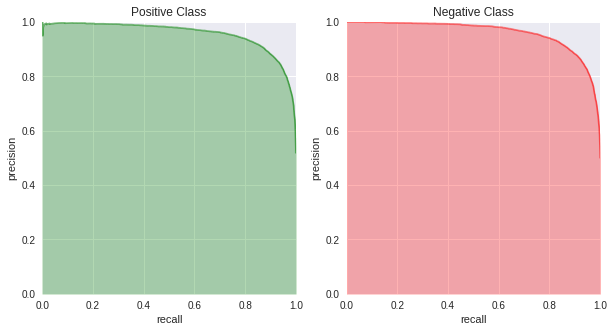

In [47]:
plt.figure(num=1,figsize=(10,5))
#Positive reviews
ax = plt.subplot(1,2,1) 
sns.lineplot(x='recall',y='precision',data=pos_pre_rec,ax=ax,color='green', alpha=0.5)
plt.fill_between(pos_pre_rec.recall.values, pos_pre_rec.precision.values, color='green', alpha=0.3)
plt.title('Positive Class')
plt.xlim(0,1)
plt.ylim(0,1)
#Negative reviews
ax = plt.subplot(1,2,2) 
sns.lineplot(x='recall',y='precision',data=neg_pre_rec,ax=ax,color='red', alpha=0.5)
plt.fill_between(neg_pre_rec.recall.values, neg_pre_rec.precision.values, color='red', alpha=0.3)
plt.title('Negative Class')
plt.xlim(0,1)
plt.ylim(0,1);

Let's now check how the average probability of being positive and the percentage of predicted positive reviews varies 
with the number of stars of the reviews

In [48]:
stars = np.unique(test_stars)
stars.sort()
my_df={'Stars': stars, 
       'Avg Prob':[test_probas[test_stars==i].mean() for i in stars],
      'Pos Revs': [(test_probas[test_stars==i]>=0.5).mean()*100 for i in stars]}

my_df = pd.DataFrame(my_df)
my_df

,Stars,Avg Prob,Pos Revs
0,1,0.095203,5.814417
1,2,0.132628,8.427454
2,3,0.181406,13.419913
3,4,0.256082,21.252372
4,7,0.767350,80.234070
5,8,0.844414,88.350877
6,9,0.878519,91.808874
7,10,0.890121,92.638528


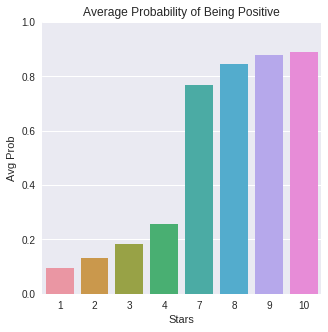

In [49]:
plt.figure(num=2,figsize=(5,5))
sns.barplot(x='Stars',y='Avg Prob',data=my_df)
plt.title('Average Probability of Being Positive')
plt.ylim(0,1);

In general, the higher the stars awarded to the review the higher the probability of it being positive based on our model (at least on average) 

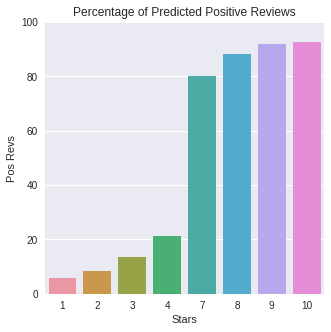

In [50]:
plt.figure(num=3,figsize=(5,5))
sns.barplot(x='Stars',y='Pos Revs',data=my_df)
plt.title('Percentage of Predicted Positive Reviews')
plt.ylim(0,100);

In general, the higher the stars awarded to the review the higher the probability of it being positive based on our model (at least on average) 

### Inference on a test review

Let's write a predict function which will output if a provided review is positive or negative, as well as the probability

In [51]:
def predict(net, test_review, sequence_length=200, alignment='right'):
    ''' Prints out whether a give review is predicted to be 
        positive or negative in sentiment, using a trained model.
        
        params:
        net - A trained net 
        test_review - a review made of normal text and punctuation
        sequence_length - the padded length of a review
        '''
    #Default sequence aligment: the one provided by the model if any
    if sequence_length is None:
        sequence_length = net.seq_length    
    #get lower case review
    test_review = test_review.lower()
    #remove some contractions
    test_review = remove_contractions(test_review)
    #remove punctuation
    test_review = ''.join([c for c in test_review if c not in punctuation])
    #split in words
    test_review = test_review.split()
    #Encode the words
    unk = net.word_to_int.get('<unk>')
    test_review = [[net.word_to_int.get(word,unk) for word in test_review[:sequence_length]]]
    #Padding
    test_review = pad_features(test_review, sequence_length, alignment=alignment)
    #Convert into pytorch tensor
    test_review = torch.from_numpy(test_review).type(torch.LongTensor).to(device)
    
    net.to(device)
    net.eval()
    pred = net(test_review).squeeze().item()
    if pred >= 0.5:
        pred = ('Positive', pred)
    else:
        pred = ('Negative', pred)
    return pred 

In [52]:
# negative test review
test_review_neg = 'The worst movie I have seen; acting was terrible and I want my money back. This movie had bad acting and the dialogue was slow.'


In [53]:
# positive test review
test_review_pos = 'This movie had the best acting and the dialogue was so good. I loved it.'

In [54]:
# call function for positive and negative reviews
print(predict(net, test_review_neg))
print(predict(net, test_review_pos))

('Negative', 0.005146815907210112)
('Positive', 0.977432906627655)


---
## Dependency of the Predictions on the Length of the Sequence

Although we have used a seqyence length of 350 words, our RNN  can actually use sequences of diffetrent lengths without modifying the net. Out of curiosity, we will test how the size of the sequences modifies the predictions for the longest misclassified review and for the longest review correctly classified.

In [55]:
#Load our best model
epoch, train_loss, valid_loss = load_checkpoint(my_path, net, optimizer)
net.to(device)
#Load test_probas
with open('GloVe_GRU_probas.pkl','rb') as f:
    test_probas = pickle.load(f)

Let's start with the corretly classified review

In [56]:
test_goodies_mask = ((test_y) == (test_probas>0.5))
test_goodies_idx = np.arange(0,len(test_y),dtype=np.int)[test_goodies_mask]
test_goodies_lens = np.array([len(test_reviews_int[idx]) for idx in test_goodies_idx])
argmax = test_goodies_lens.argmax()
my_idx = test_goodies_idx[argmax]
print(f"Length of the review: {len(test_reviews_int[my_idx])}")
print(f"Stars: {test_stars[my_idx]}\tLabel: {test_y[my_idx]}\tPrediction:{test_probas[my_idx]:.4f}")

Length of the review: 2328
Stars: 10	Label: 1	Prediction:0.9749


In [57]:
print('The review:')
with open(test_pos_dir+test_pos_rev_files[my_idx], 'r',encoding="utf8") as f:
    my_review=f.read()
    print(my_review)

The review:
There's a sign on The Lost Highway that says:<br /><br />*MAJOR SPOILERS AHEAD*<br /><br />(but you already knew that, didn't you?)<br /><br />Since there's a great deal of people that apparently did not get the point of this movie, I'd like to contribute my interpretation of why the plot makes perfect sense. As others have pointed out, one single viewing of this movie is not sufficient. If you have the DVD of MD, you can "cheat" by looking at David Lynch's "Top 10 Hints to Unlocking MD" (but only upon second or third viewing, please.) ;)<br /><br />First of all, Mulholland Drive is downright brilliant. A masterpiece. This is the kind of movie that refuse to leave your head. Not often are the comments on the DVDs very accurate, but Vogue's "It gets inside your head and stays there" really hit the mark.<br /><br />David Lynch deserves praise for creating a movie that not only has a beautifully stylish look to it - cinematography-wise, has great acting (esp. Naomi Watts), a h

In [58]:
for sl in range(200,len(test_reviews_int[my_idx]),50):
    print(f"Length:{sl}\t{predict(net, my_review, sequence_length=sl)}")

Length:200	('Positive', 0.9933426976203918)
Length:250	('Positive', 0.9831362366676331)
Length:300	('Positive', 0.9500445127487183)
Length:350	('Positive', 0.9749488234519958)
Length:400	('Positive', 0.9154666066169739)
Length:450	('Positive', 0.8916581273078918)
Length:500	('Positive', 0.9290438294410706)
Length:550	('Positive', 0.9631395936012268)
Length:600	('Positive', 0.9144543409347534)
Length:650	('Positive', 0.963345468044281)
Length:700	('Positive', 0.9733172655105591)
Length:750	('Positive', 0.9343097805976868)
Length:800	('Positive', 0.9166458249092102)
Length:850	('Positive', 0.9519183039665222)
Length:900	('Positive', 0.963681697845459)
Length:950	('Positive', 0.9747524857521057)
Length:1000	('Positive', 0.9775786399841309)
Length:1050	('Positive', 0.971552312374115)
Length:1100	('Positive', 0.9829080104827881)
Length:1150	('Positive', 0.9704629778862)
Length:1200	('Positive', 0.9230346083641052)
Length:1250	('Positive', 0.982987642288208)
Length:1300	('Positive', 0.973378

If we exclude the result with 2300 words, the network always predicts a possitive sentiment (the correct result) without much variation of the probability(0.73-0.95). It is very interesting how the probability drops to 0.46 for the las length considered, misclasifying the review as negative. That maybe due to this sentence:
*"Hope this could help people from bashing out at this movie and calling it **'the worst movie ever'** or something to that effect"*
It does not get much more negative than "the worst movie ever". 

Two factors are complicating the prediction:

1) The net was trained using sequences of 350 words. So it probably is more forgetful than it should when dealing with a 2300 word sequences and does not propely remember all the positive things said before *"the worst movie ever"*.

2) Although the test is between quotations and *'the worst movie ever'* could potentialy provide a different sentiment than *the worst movie ever*, we deleted the punctuation as part of our data preparation.



Let's see how it affects the misclassified review

In [59]:
test_error_mask = ((test_y) == (test_probas<0.5))
test_erorr_idx = np.arange(0,len(test_y),dtype=np.int)[test_error_mask]
test_error_lens = np.array([len(test_reviews_int[idx]) for idx in test_erorr_idx])
argmax = test_error_lens.argmax()
my_idx = test_erorr_idx[argmax]
print(f"Length of the review: {len(test_reviews_int[my_idx])}")
print(f"Stars: {test_stars[my_idx]}\tLabel: {test_y[my_idx]}\tPrediction:{test_probas[my_idx]:.4f}")

Length of the review: 2147
Stars: 7	Label: 1	Prediction:0.0122


In [60]:
print('The review:')
with open(test_pos_dir+test_pos_rev_files[my_idx], 'r',encoding="utf8") as f:
    my_review=f.read()
    print(my_review)

The review:
(Some spoilers included:)<br /><br />Although, many commentators have called this film surreal, the term fits poorly here. To quote from Encyclopedia Britannica's, surreal means:<br /><br />"Fantastic or incongruous imagery": One needn't explain to the unimaginative how many ways a plucky ten-year-old boy at large and seeking his fortune in the driver's seat of a red Mustang could be fantastic: those curious might read James Kincaid; but if you asked said lad how he were incongruous behind the wheel of a sports car, he'd surely protest, "NO way!" What fantasies and incongruities the film offers mostly appear within the first fifteen minutes. Thereafter we get more iterations of the same, in an ever-cruder and more squalid progression that, far from incongruous, soon proves predictable. Not that it were, on the other hand, literally believable-- but it were unfair to tax Motorama in particular with this flaw, any plausible suspension of disbelief having fallen precipitously 

In [61]:
for sl in range(200,len(test_reviews_int[my_idx]),50):
    print(f"Length:{sl}\t{predict(net, my_review, sequence_length=sl)}")

Length:200	('Negative', 0.018453430384397507)
Length:250	('Negative', 0.019829707220196724)
Length:300	('Negative', 0.0029593247454613447)
Length:350	('Negative', 0.012203792110085487)
Length:400	('Negative', 0.011524662375450134)
Length:450	('Negative', 0.020036334171891212)
Length:500	('Negative', 0.017699336633086205)
Length:550	('Negative', 0.018588325008749962)
Length:600	('Negative', 0.02527276612818241)
Length:650	('Negative', 0.0337168388068676)
Length:700	('Negative', 0.20352429151535034)
Length:750	('Negative', 0.278317928314209)
Length:800	('Negative', 0.19187146425247192)
Length:850	('Negative', 0.08950316905975342)
Length:900	('Negative', 0.008395679295063019)
Length:950	('Negative', 0.020181169733405113)
Length:1000	('Negative', 0.013488088734447956)
Length:1050	('Negative', 0.06002632528543472)
Length:1100	('Negative', 0.04306826740503311)
Length:1150	('Negative', 0.05303666740655899)
Length:1200	('Negative', 0.1857983022928238)
Length:1250	('Negative', 0.042468901723623

The probabilities vary with the sequence length (0.01-0.37) but always remained clearly below 0.5, and the review is never predicted to be positive.